In [ ]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
b2617bb6d3ffa2e429640350f613e3291e10b141
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

# Download and transform Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(f'Train+Val size: {len(train_val_dataset)}, Test size: {len(test_dataset)}')


100%|██████████| 26.4M/26.4M [00:01<00:00, 20.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 299kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.9MB/s]


Train+Val size: 60000, Test size: 10000


In [ ]:
# Split train_val into 80% train and 20% val
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Data loaders for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}')


Train size: 48000, Validation size: 12000, Test size: 10000


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

ann_model = SimpleANN()


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = SimpleCNN()


In [ ]:
import torch.optim as optim

def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100. * correct / total
    return total_loss / len(loader), accuracy

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    preds = []
    labels = []
    with torch.no_grad():
        for data, target in loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
            preds.extend(predicted.tolist())
            labels.extend(target.tolist())
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(loader)
    return accuracy, avg_loss, preds, labels

criterion = nn.CrossEntropyLoss()
ann_optimizer = optim.Adam(ann_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train over a few epochs for demonstration
num_epochs = 5
for epoch in range(num_epochs):
    ann_loss, ann_acc = train(ann_model, train_loader, criterion, ann_optimizer)
    cnn_loss, cnn_acc = train(cnn_model, train_loader, criterion, cnn_optimizer)
    print(f"Epoch {epoch}: ANN Loss {ann_loss:.4f}, ANN Acc {ann_acc:.2f}%, CNN Loss {cnn_loss:.4f}, CNN Acc {cnn_acc:.2f}%")

ann_acc, ann_loss, ann_preds, ann_labels = evaluate(ann_model, test_loader, criterion)
cnn_acc, cnn_loss, cnn_preds, cnn_labels = evaluate(cnn_model, test_loader, criterion)
print(f"Test Accuracies: ANN {ann_acc:.2f}%, CNN {cnn_acc:.2f}%")
print(f"Test Losses: ANN {ann_loss:.4f}, CNN {cnn_loss:.4f}")

Epoch 0: ANN Loss 0.3712, ANN Acc 86.40%, CNN Loss 0.2240, CNN Acc 91.65%
Epoch 1: ANN Loss 0.3319, ANN Acc 87.65%, CNN Loss 0.1490, CNN Acc 94.59%
Epoch 2: ANN Loss 0.3115, ANN Acc 88.43%, CNN Loss 0.1053, CNN Acc 96.07%
Epoch 3: ANN Loss 0.2903, ANN Acc 89.13%, CNN Loss 0.0700, CNN Acc 97.45%
Epoch 4: ANN Loss 0.2746, ANN Acc 89.69%, CNN Loss 0.0476, CNN Acc 98.22%
Test Accuracies: ANN 87.26%, CNN 92.52%
Test Losses: ANN 0.3722, CNN 0.3219


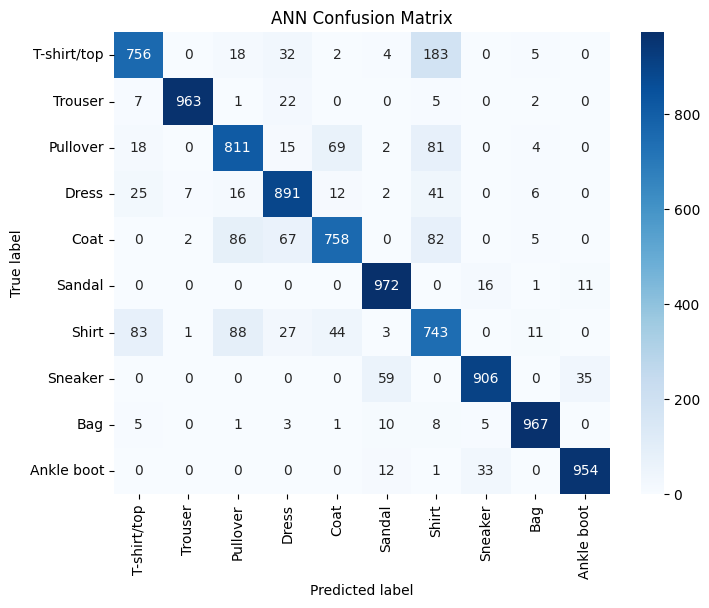

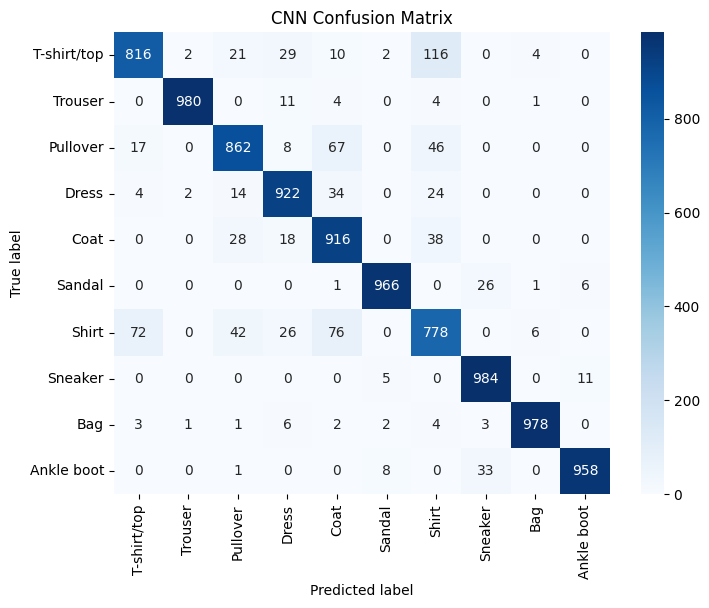

Confusion between 'Shirt' (6) and 'Coat' (4) in ANN: 44
Confusion between 'Shirt' (6) and 'Coat' (4) in CNN: 76


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Compute confusion matrices
ann_cm = confusion_matrix(ann_labels, ann_preds)
cnn_cm = confusion_matrix(cnn_labels, cnn_preds)

# Plot confusion matrices
def plot_confusion(cm, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion(ann_cm, "ANN Confusion Matrix")
plot_confusion(cnn_cm, "CNN Confusion Matrix")

# Highlight class confusions (e.g., 'Shirt' vs 'Coat')
print("Confusion between 'Shirt' (6) and 'Coat' (4) in ANN:", ann_cm[6][4])
print("Confusion between 'Shirt' (6) and 'Coat' (4) in CNN:", cnn_cm[6][4])


In [ ]:
import torch
import torch.optim as optim

# Hyperparameters to experiment with
batch_sizes = [32, 64]
learning_rates = [0.01, 0.001]
optimizers = ['SGD', 'RMSprop']

# Data loaders with dynamic batch size
def get_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


In [ ]:
def get_optimizer(model, optimizer_name, lr):
    if optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise NotImplementedError

def initialize_models():
    ann_model = SimpleANN()
    cnn_model = SimpleCNN()
    return ann_model, cnn_model


In [ ]:
criterion = nn.CrossEntropyLoss()
results = []

for batch_size in batch_sizes:
    train_loader, val_loader, test_loader = get_loaders(batch_size)
    for lr in learning_rates:
        for opt_name in optimizers:
            ann_model, cnn_model = initialize_models()

            ann_optimizer = get_optimizer(ann_model, opt_name, lr)
            cnn_optimizer = get_optimizer(cnn_model, opt_name, lr)
            print(f"\nBatchSize={batch_size}, LR={lr}, Optimizer={opt_name}")

            # Train models (short epochs for experimentation)
            num_epochs = 3
            for epoch in range(num_epochs):
                ann_loss, ann_acc = train(ann_model, train_loader, criterion, ann_optimizer)
                cnn_loss, cnn_acc = train(cnn_model, train_loader, criterion, cnn_optimizer)
                print(f"Epoch {epoch}: ANN Loss {ann_loss:.4f}, ANN Acc {ann_acc:.2f}%, CNN Loss {cnn_loss:.4f}, CNN Acc {cnn_acc:.2f}%")

            ann_acc, ann_test_loss, _, _ = evaluate(ann_model, test_loader, criterion)
            cnn_acc, cnn_test_loss, _, _ = evaluate(cnn_model, test_loader, criterion)
            print(f"ANN Test Acc: {ann_acc:.2f}% | ANN Test Loss: {ann_test_loss:.4f} | CNN Test Acc: {cnn_acc:.2f}% | CNN Test Loss: {cnn_test_loss:.4f}")

            results.append({
                'batch_size': batch_size,
                'lr': lr,
                'optimizer': opt_name,
                'ann_acc': ann_acc,
                'cnn_acc': cnn_acc,
                'ann_test_loss': ann_test_loss,
                'cnn_test_loss': cnn_test_loss
            })


BatchSize=32, LR=0.01, Optimizer=SGD
Epoch 0: ANN Loss 0.5501, ANN Acc 79.87%, CNN Loss 0.4670, CNN Acc 82.93%
Epoch 1: ANN Loss 0.3919, ANN Acc 85.61%, CNN Loss 0.2750, CNN Acc 90.05%
Epoch 2: ANN Loss 0.3508, ANN Acc 87.11%, CNN Loss 0.2213, CNN Acc 91.71%
ANN Test Acc: 85.99% | ANN Test Loss: 0.3809 | CNN Test Acc: 90.82% | CNN Test Loss: 0.2565

BatchSize=32, LR=0.01, Optimizer=RMSprop
Epoch 0: ANN Loss 1.3836, ANN Acc 74.07%, CNN Loss 5.5973, CNN Acc 76.26%
Epoch 1: ANN Loss 0.5685, ANN Acc 80.81%, CNN Loss 0.4190, CNN Acc 85.10%
Epoch 2: ANN Loss 0.5355, ANN Acc 81.81%, CNN Loss 0.3973, CNN Acc 86.45%
ANN Test Acc: 81.27% | ANN Test Loss: 0.5224 | CNN Test Acc: 86.99% | CNN Test Loss: 0.3744

BatchSize=32, LR=0.001, Optimizer=SGD
Epoch 0: ANN Loss 0.8628, ANN Acc 71.23%, CNN Loss 0.6874, CNN Acc 75.84%
Epoch 1: ANN Loss 0.4976, ANN Acc 82.19%, CNN Loss 0.4270, CNN Acc 84.60%
Epoch 2: ANN Loss 0.4428, ANN Acc 84.20%, CNN Loss 0.3666, CNN Acc 86.88%
ANN Test Acc: 83.83% | ANN Test

In [ ]:
import pandas as pd

result_df = pd.DataFrame(results)
print(result_df[['batch_size', 'lr', 'optimizer', 'ann_acc', 'cnn_acc']])

best_ann_result = result_df.loc[result_df['ann_acc'].idxmax()]
best_cnn_result = result_df.loc[result_df['cnn_acc'].idxmax()]

print("\nBest ANN Accuracy:")
print(f"Accuracy: {best_ann_result['ann_acc']:.2f}%")
print(f"Hyperparameters: Batch Size={int(best_ann_result['batch_size'])}, LR={best_ann_result['lr']}, Optimizer={best_ann_result['optimizer']}")

print("\nBest CNN Accuracy:")
print(f"Accuracy: {best_cnn_result['cnn_acc']:.2f}%")
print(f"Hyperparameters: Batch Size={int(best_cnn_result['batch_size'])}, LR={best_cnn_result['lr']}, Optimizer={best_cnn_result['optimizer']}")

   batch_size     lr optimizer  ann_acc  cnn_acc
0          32  0.010       SGD    85.99    90.82
1          32  0.010   RMSprop    81.27    86.99
2          32  0.001       SGD    83.83    87.14
3          32  0.001   RMSprop    86.59    91.28
4          64  0.010       SGD    86.01    89.77
5          64  0.010   RMSprop    81.44    85.80
6          64  0.001       SGD    81.76    84.11
7          64  0.001   RMSprop    84.00    91.34

Best ANN Accuracy:
Accuracy: 86.59%
Hyperparameters: Batch Size=32, LR=0.001, Optimizer=RMSprop

Best CNN Accuracy:
Accuracy: 91.34%
Hyperparameters: Batch Size=64, LR=0.001, Optimizer=RMSprop
